# Preprocessing and filtering raw data
### 1. Packages Initliazation 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

# # import tensorflow as tf
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import LSTM, Dense
# # from tensorflow.keras.optimizers import Adam

### 2. Unpacking pickle files and removing unwanted batteries 

In [32]:
batch1 = pickle.load(open(r'.\Data\batch1.pkl', 'rb'))
batch2 = pickle.load(open(r'.\Data\batch2.pkl','rb'))
batch3 = pickle.load(open(r'.\Data\batch3.pkl','rb'))

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1

batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];


In [33]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [34]:
#remove batteries that do not reach 80% capacity

del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [35]:
numBat1 = len(batch1.keys())
numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
numBat

print(f'Batch1 :',numBat1)
print(f'Batch2 :',numBat2)
print(f'Batch3 :',numBat3)
print(f'Total batch :', numBat)

bat_dict = {**batch1, **batch2, **batch3}
bat_dict.keys()

Batch1 : 42
Batch2 : 43
Batch3 : 40
Total batch : 125


dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29'

### 3. Plotting battery parameters

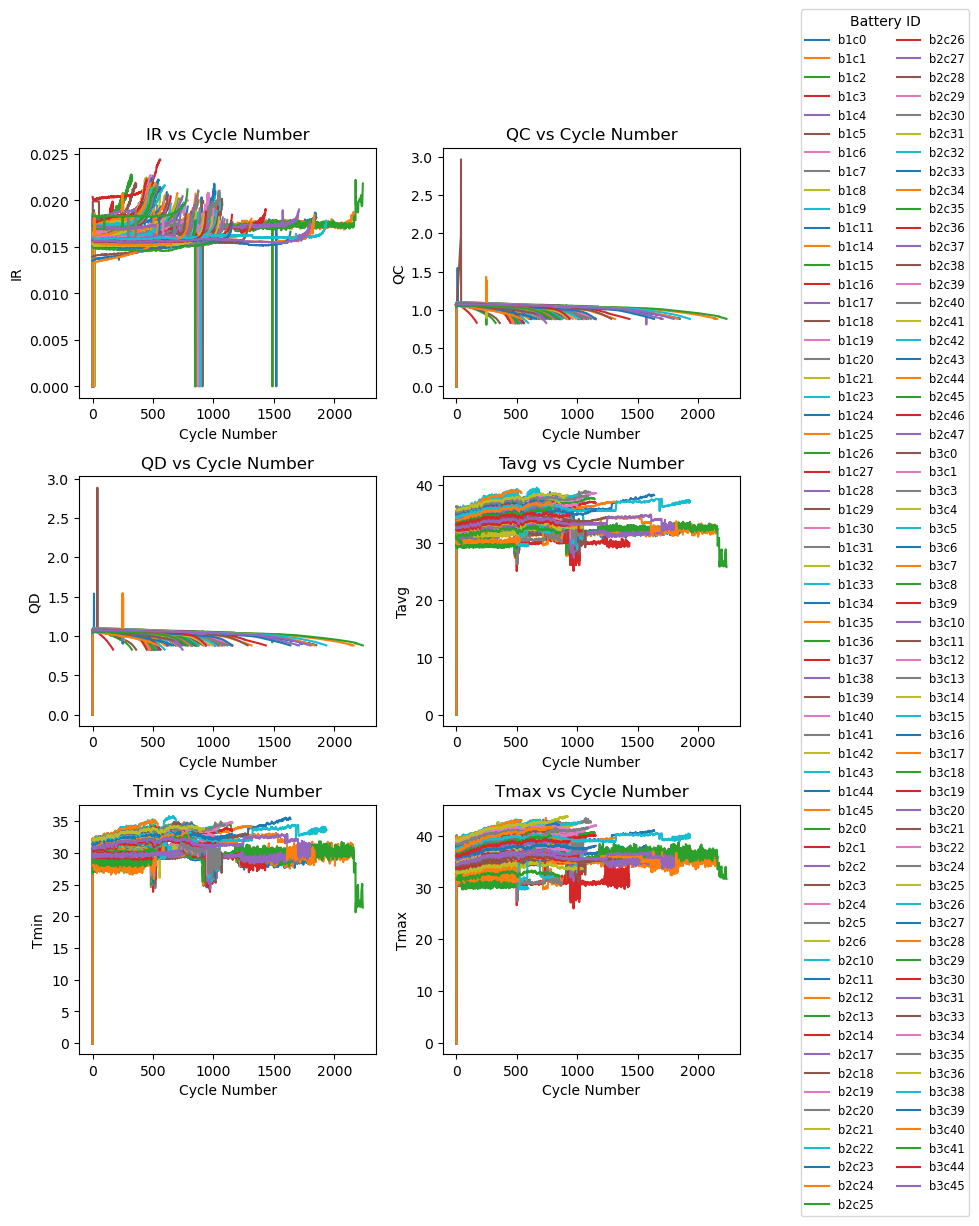

In [36]:
import matplotlib.pyplot as plt

# Remove 'chargetime' and update features to be plotted
features_to_plot = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax']

# Create a 3x2 grid for subplots (for 6 features)
fig, axes = plt.subplots(3, 2, figsize=(8, 10))  
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# For storing the plot lines and labels for a shared legend
lines = []
labels = []

# Plot each feature on a separate subplot
for idx, feature in enumerate(features_to_plot):
    for i in bat_dict.keys():
        line, = axes[idx].plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary'][feature], label=i)  
        if idx == 0:  # Collect labels from the first plot only for a shared legend
            lines.append(line)
            labels.append(i)
    axes[idx].set_title(f'{feature} vs Cycle Number')  # Set title for each subplot
    axes[idx].set_xlabel('Cycle Number')
    axes[idx].set_ylabel(feature)

# Remove the last empty subplot if any
if len(features_to_plot) < len(axes):
    fig.delaxes(axes[-1])

# Create a single legend for the entire figure
fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title="Battery ID", ncol=2)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout so the legend fits nicely outside
plt.show()


### 4. Train and Test Split (As per the paper)
If you are interested in using the same train/test split as the paper, use the indices specified below

In [37]:
test_ind = np.arange(0,(numBat1+numBat2),2)                 # Batteries 0 to 83 (all even indices) -44 batteries
train_ind = np.arange(1,(numBat1+numBat2-1),2)              # Batteries 0 to 83 (all odd indices) - 42 batteries
secondary_test_ind = np.arange(numBat-numBat3,numBat);      # Batteries 84 to 126 - 40 batteries

In [38]:
train_data = {list(bat_dict.keys())[i]: bat_dict[list(bat_dict.keys())[i]] for i in train_ind if i < len(bat_dict)}
valida_data = {list(bat_dict.keys())[i]: bat_dict[list(bat_dict.keys())[i]] for i in test_ind if i < len(bat_dict)}
test_data = {list(bat_dict.keys())[i]: bat_dict[list(bat_dict.keys())[i]] for i in secondary_test_ind if i < len(bat_dict)}

batch1.keys()  

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

### 5. Data structure (for each battery as key)



In [39]:
"""
batch entry structure (for refernce):

batch1['b1c0']
│
├── cycle_life: NumPy array
│       [1852.]
│
├── charge_policy: String
│       "3.6C(80%)-3.6C"
│
├── summary: Dictionary
│   ├── IR: NumPy array (Internal Resistance over cycles)
│   ├── QC: NumPy array (Charge Capacity over cycles)
│   ├── QD: NumPy array (Discharge Capacity over cycles)
│   ├── Tavg: NumPy array (Average Temperature over cycles)
│   ├── Tmin: NumPy array (Minimum Temperature over cycles)
│   ├── Tmax: NumPy array (Maximum Temperature over cycles)
│   ├── chargetime: NumPy array (Charging time over cycles)
│   └── cycle: NumPy array (Cycle numbers)
│
└── cycles: Dictionary (Detailed per-cycle data)
    ├── '0': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    ├── '1': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    └── ... : Additional cycles ('2', '3', ..., '1851')
    """

'\nbatch entry structure (for refernce):\n\nbatch1[\'b1c0\']\n│\n├── cycle_life: NumPy array\n│       [1852.]\n│\n├── charge_policy: String\n│       "3.6C(80%)-3.6C"\n│\n├── summary: Dictionary\n│   ├── IR: NumPy array (Internal Resistance over cycles)\n│   ├── QC: NumPy array (Charge Capacity over cycles)\n│   ├── QD: NumPy array (Discharge Capacity over cycles)\n│   ├── Tavg: NumPy array (Average Temperature over cycles)\n│   ├── Tmin: NumPy array (Minimum Temperature over cycles)\n│   ├── Tmax: NumPy array (Maximum Temperature over cycles)\n│   ├── chargetime: NumPy array (Charging time over cycles)\n│   └── cycle: NumPy array (Cycle numbers)\n│\n└── cycles: Dictionary (Detailed per-cycle data)\n    ├── \'0\': Dictionary\n    │   ├── I: NumPy array (Current data)\n    │   ├── Qc: NumPy array (Charge capacity data)\n    │   ├── Qd: NumPy array (Discharge capacity data)\n    │   ├── Qdlin: NumPy array (Linearized discharge capacity)\n    │   ├── T: NumPy array (Temperature data)\n    

# Feature Engineering

### 1. Filtering (z-score based) and strandadizing train, test and validation data 

In [40]:
def add_cleaned_summary(data_dict):
    for key in data_dict:
        cleaned_summary = pd.DataFrame(data_dict[key]['summary']).copy()
        z_scores = np.abs(zscore(cleaned_summary.iloc[:, 0:-1]))
        threshold = 3
        filtered_entries = (z_scores < threshold).all(axis=1)
        cleaned_summary = cleaned_summary[filtered_entries]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(cleaned_summary.iloc[:, 0:-1])
        cleaned_summary.iloc[:, 0:-1] = scaled_features
        data_dict[key]['cleaned_summary'] = cleaned_summary

add_cleaned_summary(train_data)
add_cleaned_summary(test_data)
add_cleaned_summary(valida_data)

In [41]:
features = train_data['b1c1']['cleaned_summary'].iloc[:, 0:-1]

In [42]:
# # For Battery b1c0 (To be delted after generalization)

# b1c0_summary_df = pd.DataFrame(batch1['b1c0']['summary'])
# features = pd.DataFrame(batch1['b1c0']['summary']).iloc[:, 0:-1]
# target = pd.DataFrame(batch1['b1c0']['summary']).iloc[:,-1]
# features.head()
# z_scores = np.abs(zscore(features))
# threshold = 3
# filtered_entries = (z_scores < threshold).all(axis=1)
# features = features[filtered_entries]


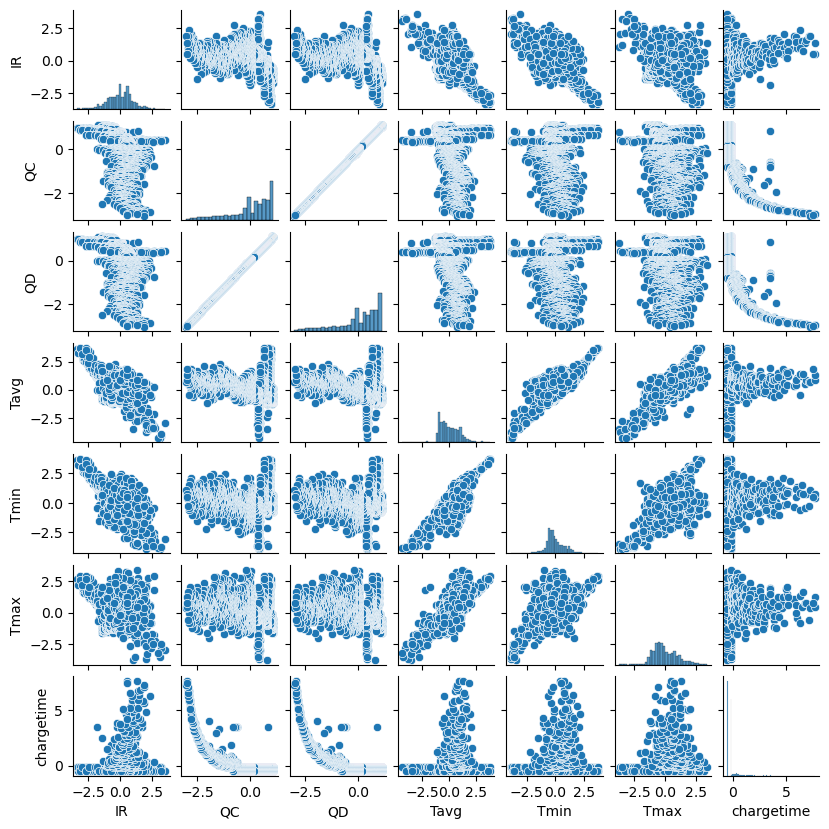

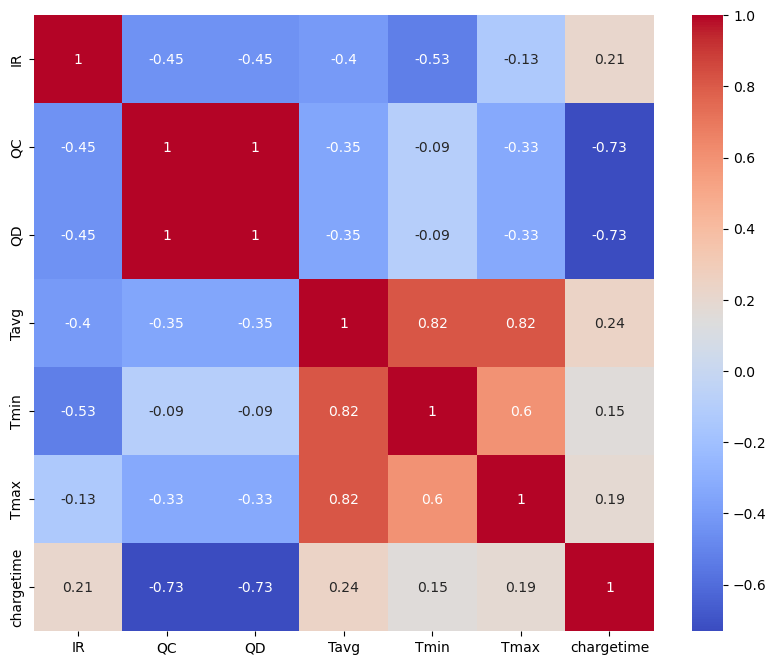

In [43]:
# plt.figure(figsize=(8,6))
sns.pairplot(features, height=1.2 )
plt.show()

correlation_matrix = features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [44]:

reduced_features = features.copy()
reduced_features['Capacity_Ratio'] = reduced_features['QC'] / reduced_features['QD']
reduced_features['T_del'] = reduced_features['Tmax'] - reduced_features['Tmin']
reduced_features['ChargeTime_per_Qc'] = reduced_features['chargetime'] / reduced_features['QC']
reduced_features = reduced_features.drop(['QC', 'QD', 'Tmin', 'Tmax'], axis=1)

# This take too much time, uncomment if you want to run it

# sample_data = reduced_features
# # sample_data = reduced_features.sample(1000)  # Adjust as needed
# sns.pairplot(reduced_features[['Capacity_Ratio', 'T_del', 'ChargeTime_per_Qc', 'IR']], height=1.5)
# plt.show()

# correlation_matrix = reduced_features.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()


### 2. Data Processing for Cycles data

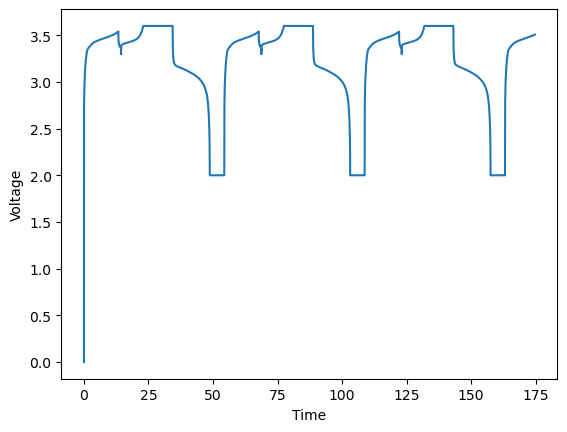

In [45]:
# Ali's Code - for combining all cycles into one dataframe


# Initialize an empty dictionary to store the data for each battery in New_Batch1
New_Batch1 = {}

# Loop over the list and create new "variables" for each battery in batch1
for j in batch1.keys():
    new_var_name = f"New_{j}"  # Create a new variable name

    # Calculate the total number of time points across all cycles for battery 'j'
    ii = 0
    for i in range(len(batch1[j]['cycles'].keys())):
        l = len(batch1[j]['cycles'][str(i)]['t'])
        ii += l

    # Number of columns should match the number of parameters you want to extract from each cycle
    n_columns = 6  # 6 parameters: t, I, Qc, Qd, T, V

    # Create an empty NumPy array with the total number of time points (ii) and 6 columns
    new_variables = {}  # Define new_variables as an empty dictionary
    new_variables[new_var_name] = np.zeros((ii, n_columns))

    # Variable to track where we should start inserting data in new_variables[new_var_name]
    start_idx = 0

    # Loop through each cycle and append its data to the corresponding array
    for i in range(len(batch1[j]['cycles'].keys())):
        cycle_data = batch1[j]['cycles'][str(i)]
        l = len(cycle_data['t'])

        # Fill the new_variables array for this cycle
        if start_idx == 0:
            new_variables[new_var_name][start_idx:start_idx + l, 0] = cycle_data['t']
        else:
            new_variables[new_var_name][start_idx:start_idx + l, 0] = cycle_data['t'] + new_variables[new_var_name][start_idx - 1, 0]  # Time

        new_variables[new_var_name][start_idx:start_idx + l, 1] = cycle_data['I']  # Current
        new_variables[new_var_name][start_idx:start_idx + l, 2] = cycle_data['Qc']  # Charge capacity
        new_variables[new_var_name][start_idx:start_idx + l, 3] = cycle_data['Qd']  # Discharge capacity
        new_variables[new_var_name][start_idx:start_idx + l, 4] = cycle_data['T']  # Temperature
        new_variables[new_var_name][start_idx:start_idx + l, 5] = cycle_data['V']  # Voltage

        # Update the starting index for the next cycle
        start_idx += l

    # Optionally, slice to remove any unused rows (if necessary)
    new_variables[new_var_name] = new_variables[new_var_name][0:start_idx, :]

    # Store the data for this battery in the New_Batch1 dictionary
    New_Batch1[new_var_name] = new_variables[new_var_name]


# Example: Plotting voltage vs. time for New_b1c0
plt.plot(New_Batch1['New_b1c0'][:3600, 0], New_Batch1['New_b1c0'][:3600, 5])
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()



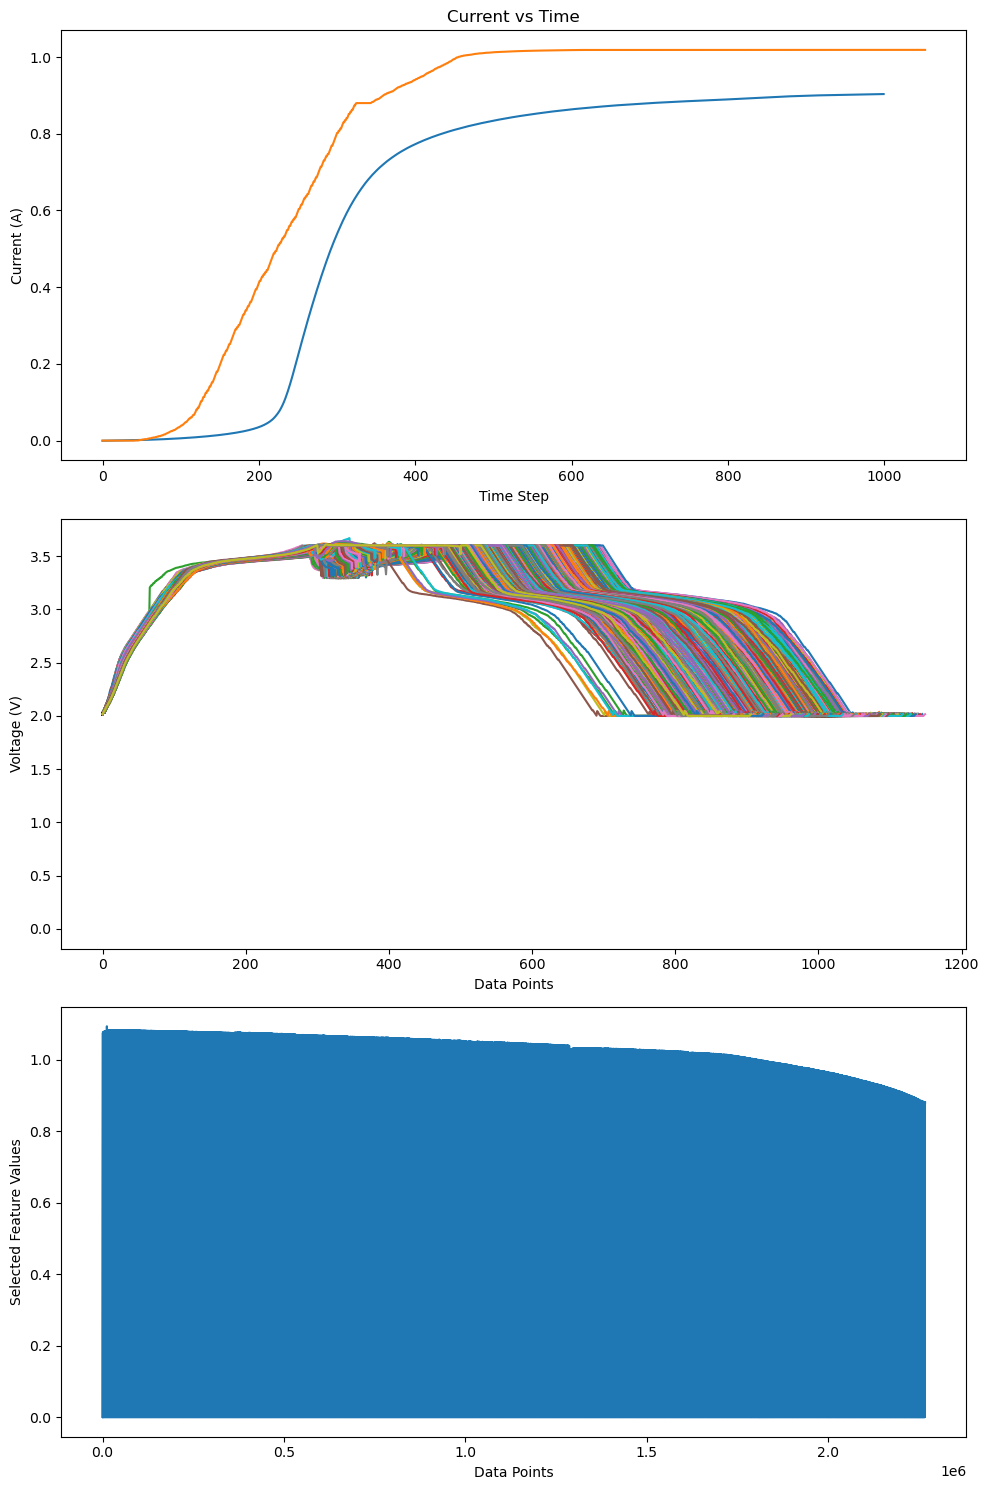

In [46]:
# Adeel's Code - for combining all cycles into one dataframe - Still buggy

data = train_data
batt = 'b1c1'
c1 = '2000'
c2 = '1500'
f1 = 'Qdlin'
f2 = 'Qc'

# Initialize the figure with a specified size and layout
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot 1: Feature comparison for the same battery but different cycles
axs[0].plot(data[batt]['cycles'][c1][f1], label=f'{f1} for Cycle {c1}')
x = data[batt]['cycles'][c2][f2]
axs[0].plot(np.arange(len(x)), x, label=f'{f2} for Cycle {c2}')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Current (A)')
axs[0].set_title('Current vs Time')


# Plot 2: Feature comparison across different cycles for the same battery
for key in data[batt]['cycles'].keys():  
    x = data[batt]['cycles'][key]['V'] 
    axs[1].plot(x, label=f'Cycle {key}')
axs[1].set_xlabel('Data Points')  
axs[1].set_ylabel('Voltage (V)')  

# Plot 3: Combined feature comparison across all cycles for the same feature
selected_feature = []
for key in data[batt]['cycles'].keys():  
    x = data[batt]['cycles'][key][f2] 
    selected_feature.append(x)  
combined = np.concatenate(selected_feature)
axs[2].plot(combined, label=f'Combined {f2} values across all cycles')
axs[2].set_xlabel('Data Points')
axs[2].set_ylabel('Selected Feature Values')


# Show all plots in a single combined image
plt.tight_layout()
plt.show()


# Algorthm implementation
### 1. Random Forest implementation

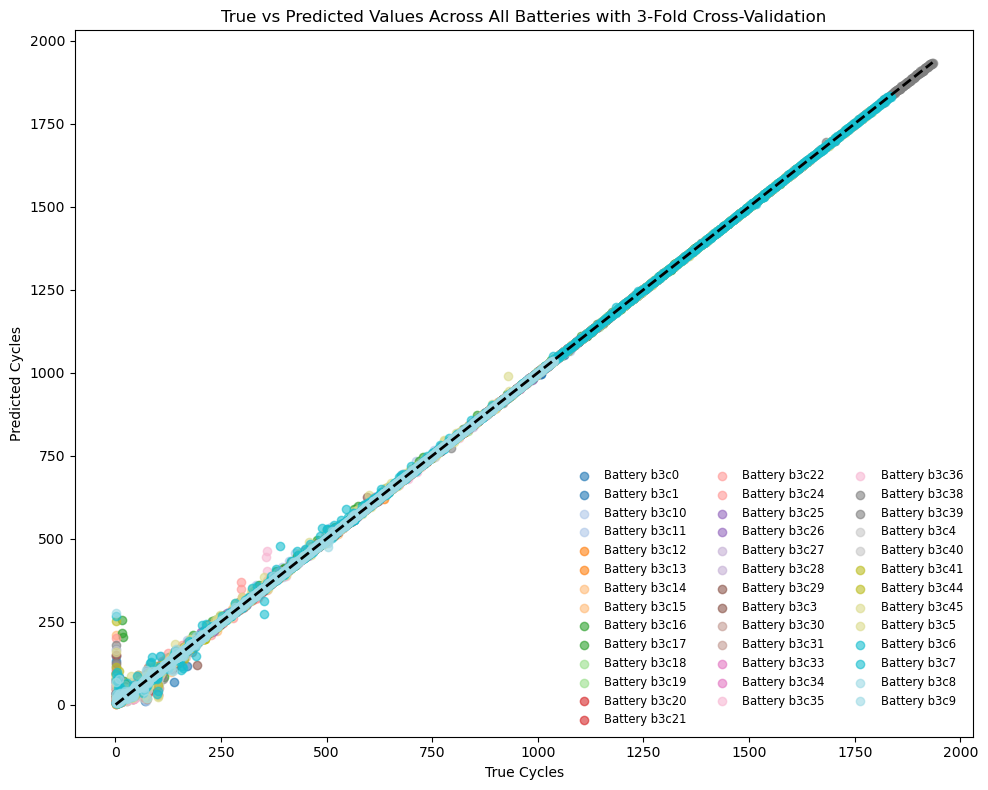

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store the metrics and predictions
mse_list = []
r2_list = []
battery_names = []

# Lists to store all true and predicted values across all batteries and folds
all_y_test = []
all_y_pred = []
all_battery_ids = []

# Number of folds for cross-validation
k = 3

# Iterate over each battery in batch1
for battery_key in test_data.keys():
    battery_summary_df = pd.DataFrame(test_data[battery_key]['summary'])
    features = battery_summary_df.iloc[:, :-1]
    target = battery_summary_df.iloc[:, -1]

    # Check if there is enough data to perform K-fold cross-validation
    if len(features) < k:
        print(f"Not enough data for battery {battery_key} to perform {k}-fold cross-validation. Skipping...")
        continue

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    fold_mse = []
    fold_r2 = []

    # Lists to store true and predicted values for each fold
    battery_y_test = []
    battery_y_pred = []

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store metrics for this fold
        fold_mse.append(mse)
        fold_r2.append(r2)

        # Store true and predicted values
        battery_y_test.extend(y_test)
        battery_y_pred.extend(y_pred)

    # Compute average metrics across folds for this battery
    avg_mse = np.mean(fold_mse)
    avg_r2 = np.mean(fold_r2)

    # Store the average metrics
    mse_list.append(avg_mse)
    r2_list.append(avg_r2)
    battery_names.append(battery_key)

    # Store the true and predicted values along with battery ID
    all_y_test.extend(battery_y_test)
    all_y_pred.extend(battery_y_pred)
    all_battery_ids.extend([battery_key] * len(battery_y_test))

# Convert lists to numpy arrays for plotting
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_battery_ids = np.array(all_battery_ids)

# Create a color map for batteries
unique_batteries = np.unique(all_battery_ids)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_batteries)))
color_map = dict(zip(unique_batteries, colors))

# Plotting
plt.figure(figsize=(10, 8))
for battery in unique_batteries:
    idx = all_battery_ids == battery
    plt.scatter(
        all_y_test[idx],
        all_y_pred[idx],
        alpha=0.6,
        label=f'Battery {battery}',
        color=color_map[battery]
    )

# Plot the ideal line
min_val = min(all_y_test.min(), all_y_pred.min())
max_val = max(all_y_test.max(), all_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('True Cycles')
plt.ylabel('Predicted Cycles')
plt.title('True vs Predicted Values Across All Batteries with 3-Fold Cross-Validation')

# Adjust the legend
plt.legend(
    fontsize='smaller',
    loc='lower right',
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()

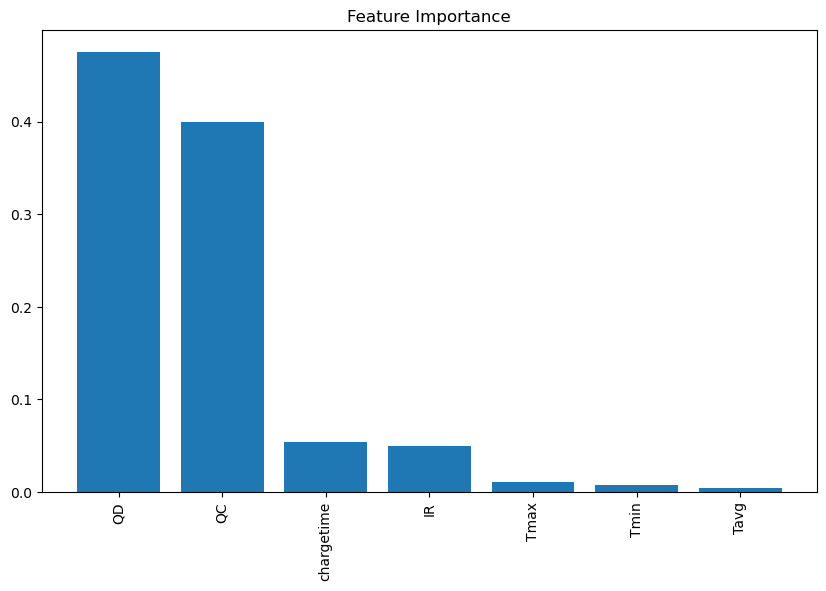

In [22]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(features.shape[1]), importances[indices], align="center")
plt.xticks(range(features.shape[1]), features.columns[indices], rotation=90)
plt.show()


In [23]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_regressor, features, target, cv=5, scoring='r2')

# Print the cross-validation R-squared scores
print("Cross-Validation R-squared Scores:", cv_scores)
print("Mean R-squared Score:", np.mean(cv_scores))


Cross-Validation R-squared Scores: [ -5.29730607   0.60131287  -0.30100859  -0.04938771 -14.72343784]
Mean R-squared Score: -3.9539654670851667


Cylces - Analysis

What to do next?
1- Stack features and add it to the original df with same keys
2- Make sub dataframes for new features and make heatmap for their corelations.
    a - Features combining using PCA Tavg, Tmin, and Tmax & QC and QD
    b - Multicolinearity and Polynomial feature
    c- VIF, Pearson correlation coefficient, Spearman's rank correlation


### LSTM implementation

In [24]:
# # Initialize lists to store the metrics and predictions
# mse_list = []
# r2_list = []
# battery_names = []

# # Lists to store all true and predicted values across all batteries and folds
# all_y_test = []
# all_y_pred = []
# all_battery_ids = []

# # Number of folds for cross-validation
# k = 3

# # Iterate over each battery in batch1
# for battery_key in batch1.keys():
#     battery_summary_df = pd.DataFrame(batch1[battery_key]['summary'])

#     # Assuming 'time' is a column representing the sequence order
#     # and that the data is sorted by 'time'
#     # If not, sort the data
#     # battery_summary_df = battery_summary_df.sort_values('time')

#     features = battery_summary_df.iloc[:, :-1].values  # Convert to NumPy array
#     target = battery_summary_df.iloc[:, -1].values     # Convert to NumPy array

#     # Check if there is enough data to perform K-fold cross-validation
#     if len(features) < k:
#         print(f"Not enough data for battery {battery_key} to perform {k}-fold cross-validation. Skipping...")
#         continue

#     # Reshape features for LSTM: (samples, timesteps, features)
#     # Here, we'll assume timesteps = 1 (since we have tabular data)
#     # If you have sequences, adjust timesteps accordingly
#     features = features.reshape((features.shape[0], 1, features.shape[1]))

#     # Initialize KFold
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)

#     # Lists to store metrics for each fold
#     fold_mse = []
#     fold_r2 = []

#     # Lists to store true and predicted values for each fold
#     battery_y_test = []
#     battery_y_pred = []

#     # Perform K-fold cross-validation
#     fold = 1
#     for train_index, test_index in kf.split(features):
#         print(f"Battery {battery_key}, Fold {fold}")

#         X_train, X_test = features[train_index], features[test_index]
#         y_train, y_test = target[train_index], target[test_index]

#         # Define the LSTM model
#         model = Sequential()
#         model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
#         model.add(Dense(1))  # Output layer for regression
#         model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#         # Train the model
#         history = model.fit(
#             X_train, y_train,
#             epochs=50,
#             batch_size=16,
#             validation_data=(X_test, y_test),
#             verbose=0  # Set to 1 to see training progress
#         )

#         # Predict on the test set
#         y_pred = model.predict(X_test).flatten()

#         mse = mean_squared_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)

#         # Store metrics for this fold
#         fold_mse.append(mse)
#         fold_r2.append(r2)

#         # Store true and predicted values
#         battery_y_test.extend(y_test)
#         battery_y_pred.extend(y_pred)

#         fold += 1

#     # Compute average metrics across folds for this battery
#     avg_mse = np.mean(fold_mse)
#     avg_r2 = np.mean(fold_r2)

#     # Store the average metrics
#     mse_list.append(avg_mse)
#     r2_list.append(avg_r2)
#     battery_names.append(battery_key)

#     # Store the true and predicted values along with battery ID
#     all_y_test.extend(battery_y_test)
#     all_y_pred.extend(battery_y_pred)
#     all_battery_ids.extend([battery_key] * len(battery_y_test))

# # Convert lists to numpy arrays for plotting
# all_y_test = np.array(all_y_test)
# all_y_pred = np.array(all_y_pred)
# all_battery_ids = np.array(all_battery_ids)

# # Create a color map for batteries
# unique_batteries = np.unique(all_battery_ids)
# colors = plt.cm.tab20(np.linspace(0, 1, len(unique_batteries)))
# color_map = dict(zip(unique_batteries, colors))

# # Plotting
# plt.figure(figsize=(10, 8))
# for battery in unique_batteries:
#     idx = all_battery_ids == battery
#     plt.scatter(
#         all_y_test[idx],
#         all_y_pred[idx],
#         alpha=0.6,
#         label=f'Battery {battery}',
#         color=color_map[battery]
#     )

# # Plot the ideal line
# min_val = min(all_y_test.min(), all_y_pred.min())
# max_val = max(all_y_test.max(), all_y_pred.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# plt.xlabel('True Cycles')
# plt.ylabel('Predicted Cycles')
# plt.title('True vs Predicted Values Across All Batteries with 3-Fold Cross-Validation (LSTM)')

# # Adjust the legend
# plt.legend(
#     fontsize='smaller',
#     loc='lower right',
#     ncol=3,
#     frameon=False
# )

# plt.tight_layout()
# plt.show()
